In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy import stats
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GroupKFold
from imblearn.over_sampling import RandomOverSampler
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
import torch.nn.functional as F

## 데이터 로드 / EDA / 전처리

### 데이터 로드

In [3]:
file = open("C:/Users/c/Desktop/ML programming/WISDM_ar_v1.1_raw.txt")

In [4]:
lines = file.readlines()

processedList = []

for i, line in enumerate(lines):
    try:
        line = line.split(',')
        last = line[5].split(';')[0]
        last = last.strip()
        if last == '':
            break;
        temp = [line[0], line[1], line[2], line[3], line[4], last]
        processedList.append(temp)
    except:
        print('Error at line number: ', i)

Error at line number:  281873
Error at line number:  281874
Error at line number:  281875


In [5]:
# 컬럼 추가
columns = ['user', 'activity', 'time', 'x', 'y', 'z']

In [6]:
df = pd.DataFrame(data = processedList, columns = columns)
df['x'] = df['x'].astype('float')
df['y'] = df['y'].astype('float')
df['z'] = df['z'].astype('float')
df['user'] = df['user'].astype('int')
df.head()

,user,activity,time,x,y,z
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


### EDA

In [7]:
df.isnull().sum()

user        0
activity    0
time        0
x           0
y           0
z           0
dtype: int64

In [8]:
df['activity'].value_counts()

activity
Walking       137375
Jogging       129392
Upstairs       35137
Downstairs     33358
Sitting         4599
Standing        3555
Name: count, dtype: int64

C:\Users\c\AppData\Local\Temp\ipykernel_16660\3400418400.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=user_counts.index, y=user_counts.values, palette='viridis')


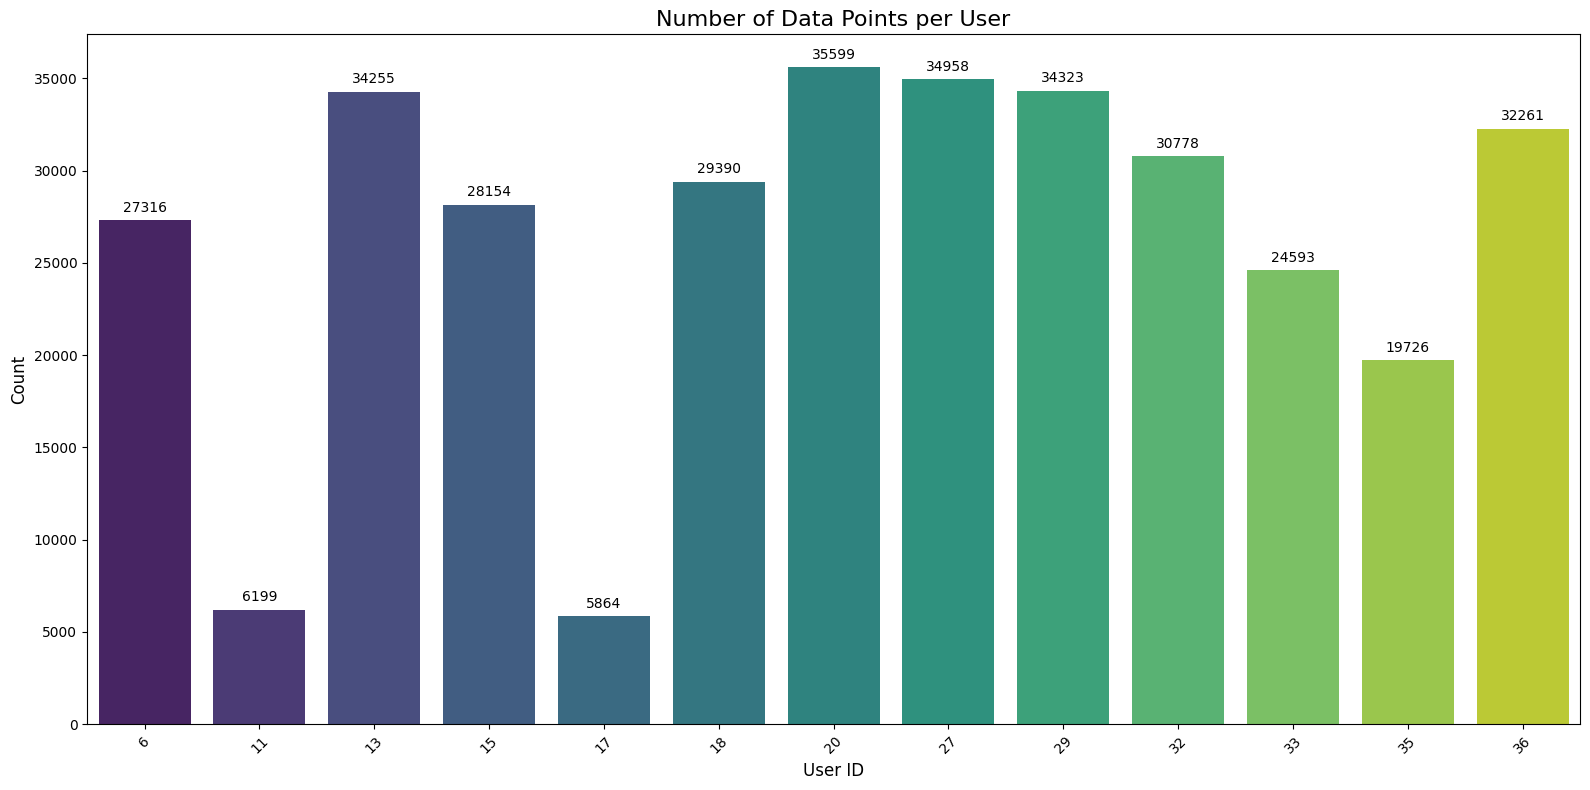

In [9]:
user_counts = df['user'].value_counts()

plt.figure(figsize=(16, 8)) 
barplot = sns.barplot(x=user_counts.index, y=user_counts.values, palette='viridis')

for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.0f'),
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha = 'center', va = 'center',
                     xytext = (0, 9),
                     textcoords = 'offset points')

plt.title('Number of Data Points per User', fontsize=16)
plt.xlabel('User ID', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45) 
plt.tight_layout() 
plt.show()

C:\Users\c\AppData\Local\Temp\ipykernel_16660\1733336201.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Group', y='Total Count', data=comparison_df, palette='rocket')


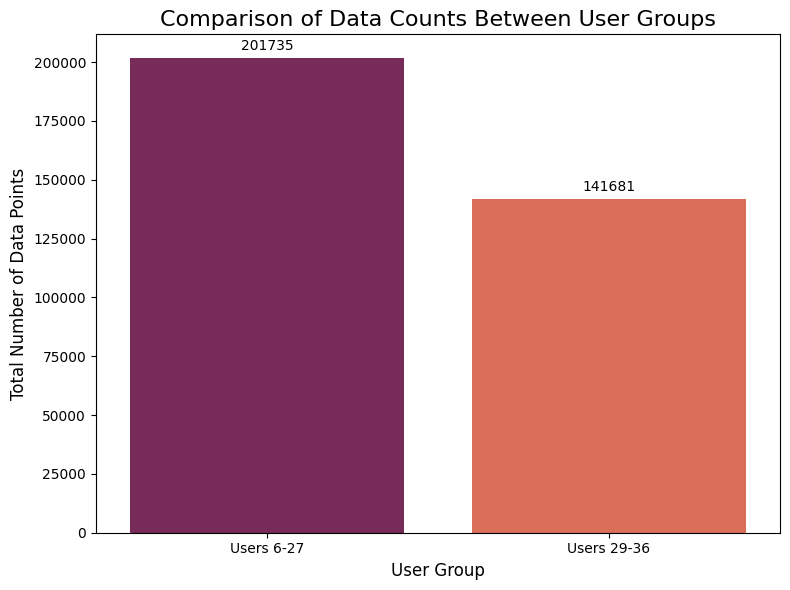

In [10]:
user_counts = df['user'].value_counts()

group_a_mask = (user_counts.index >= 6) & (user_counts.index <= 27)
group_a_sum = user_counts[group_a_mask].sum()

group_b_mask = (user_counts.index >= 29) & (user_counts.index <= 36)
group_b_sum = user_counts[group_b_mask].sum()

plt.figure(figsize=(8, 6))
comparison_df = pd.DataFrame({
    'Group': ['Users 6-27', 'Users 29-36'],
    'Total Count': [group_a_sum, group_b_sum]
})
barplot = sns.barplot(x='Group', y='Total Count', data=comparison_df, palette='rocket')

for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.0f'),
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha = 'center', va = 'center',
                     xytext = (0, 9),
                     textcoords = 'offset points')

plt.title('Comparison of Data Counts Between User Groups', fontsize=16)
plt.ylabel('Total Number of Data Points', fontsize=12)
plt.xlabel('User Group', fontsize=12)
plt.tight_layout()
plt.show()

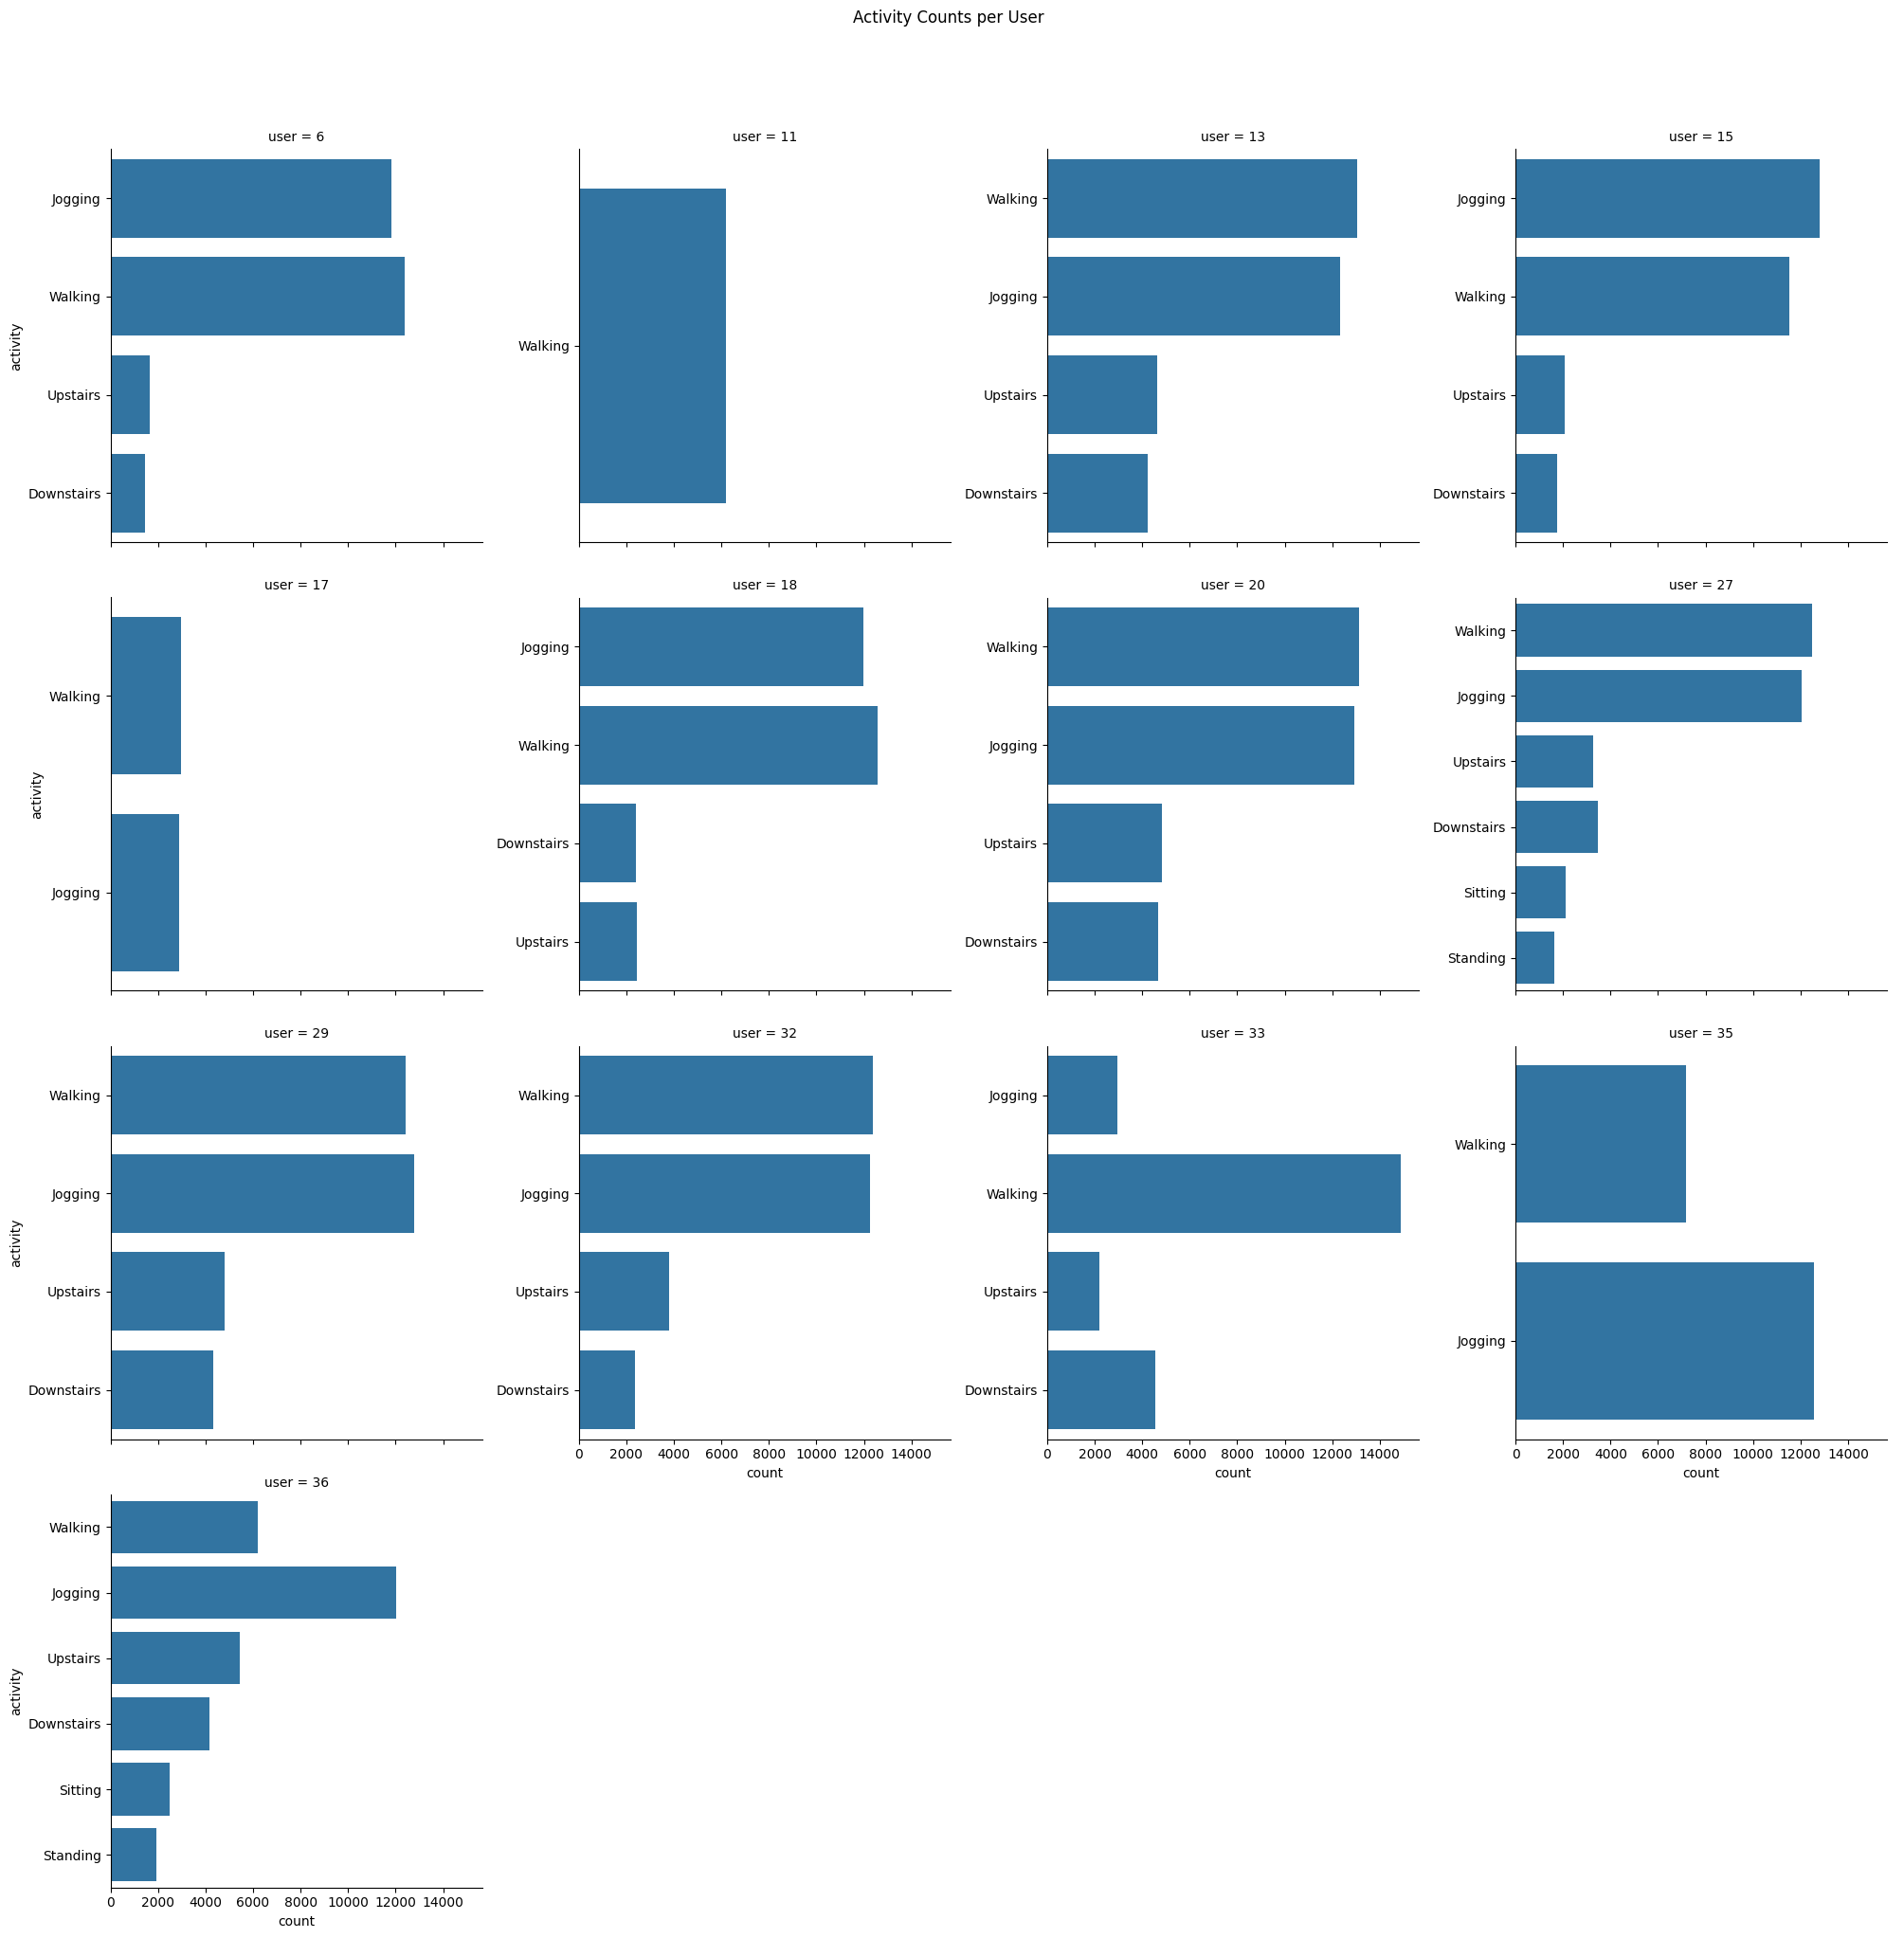

In [11]:
g = sns.catplot(data=df, y='activity', col='user', kind='count', 
                height=5, aspect=1, col_wrap=4, sharey=False)

g.fig.suptitle('Activity Counts per User', y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

### 전처리

In [12]:
test_df = df[df['user'] > 27]
train_df = df[df['user'] <= 27]
test_df.shape, train_df.shape

((141681, 6), (201735, 6))

In [13]:
def feature_engineering(df):
    df['magnitude'] = np.sqrt(df['x']**2 + df['y']**2 + df['z']**2)
        
    feature_cols = ['x', 'y', 'z', 'magnitude']
    for col in feature_cols:

        df[f'{col}_std'] = df.groupby('user')[col].rolling(
            window=80, 
            min_periods=1
        ).std().reset_index(level=0, drop=True)
        
    df.fillna(method='ffill', inplace=True)
    df.fillna(0, inplace=True)
    return df

test_df = feature_engineering(test_df)
train_df = feature_engineering(train_df)

test_df.head(), train_df.head()


C:\Users\c\AppData\Local\Temp\ipykernel_16660\1676528177.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['magnitude'] = np.sqrt(df['x']**2 + df['y']**2 + df['z']**2)
C:\Users\c\AppData\Local\Temp\ipykernel_16660\1676528177.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{col}_std'] = df.groupby('user')[col].rolling(
C:\Users\c\AppData\Local\Temp\ipykernel_16660\1676528177.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

(   user activity            time         x          y         z  magnitude  \
 0    33  Jogging  49105962326000 -0.694638  12.680544  0.503953  12.709551   
 1    33  Jogging  49106062271000  5.012288  11.264028  0.953424  12.365693   
 2    33  Jogging  49106112167000  4.903325  10.882658 -0.081722  11.936562   
 3    33  Jogging  49106222305000 -0.612916  18.496431  3.023717  18.751973   
 4    33  Jogging  49106332290000 -1.184970  12.108489  7.205164  14.139804   
 
       x_std     y_std     z_std  magnitude_std  
 0  0.000000  0.000000  0.000000       0.000000  
 1  4.035406  1.001628  0.317824       0.243144  
 2  3.263895  0.947308  0.519065       0.387277  
 3  3.240326  3.529472  1.350791       3.222902  
 4  3.178345  3.105116  2.970432       2.792531  ,
       user activity            time         x          y         z  magnitude  \
 8489    17  Walking  57869902574000  0.572055   9.806650 -0.531194   9.837672   
 8490    17  Walking  57870012316000 -0.000000  10.188020 -

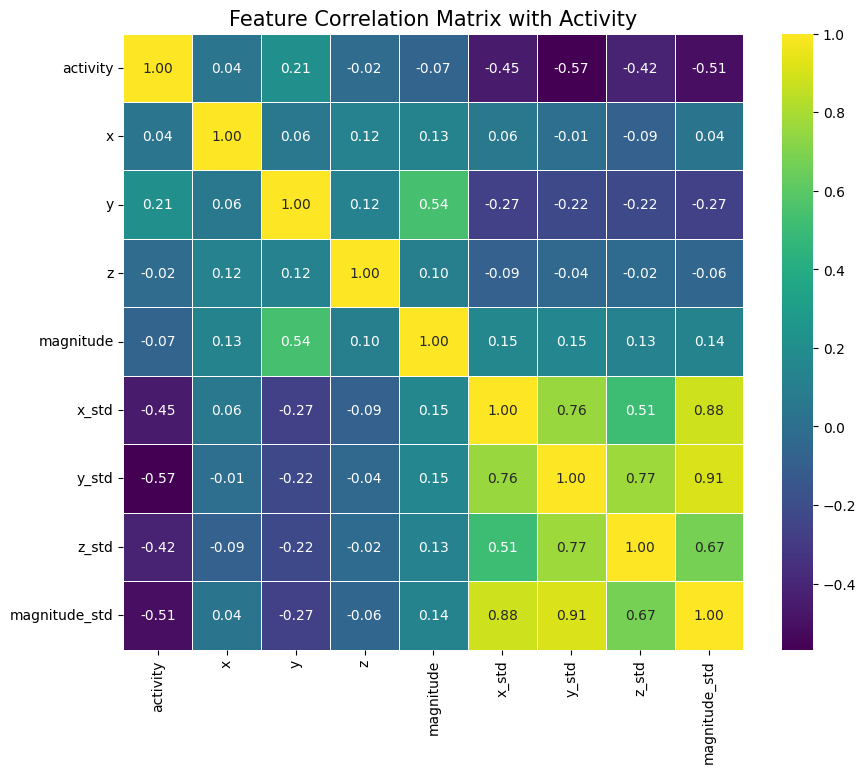

In [14]:
corr_df = train_df.copy()

# 시각화용 LabelEncoder 생성 및 적용
le_corr = LabelEncoder()
corr_df['activity'] = le_corr.fit_transform(corr_df['activity'])

# 상관관계 분석할 특성 선택 (activity 포함)
features_for_corr = ['activity', 'x', 'y', 'z', 'magnitude', 'x_std', 'y_std', 'z_std', 'magnitude_std']
corr_matrix = corr_df[features_for_corr].corr()

# 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='viridis', fmt='.2f', linewidths=.5)
plt.title('Feature Correlation Matrix with Activity', fontsize=15)
plt.show()


In [15]:
label_encoder = LabelEncoder()

train_df['activity'] = label_encoder.fit_transform(train_df['activity'])
test_df['activity'] = label_encoder.transform(test_df['activity'])

C:\Users\c\AppData\Local\Temp\ipykernel_16660\4128002732.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['activity'] = label_encoder.fit_transform(train_df['activity'])
C:\Users\c\AppData\Local\Temp\ipykernel_16660\4128002732.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['activity'] = label_encoder.transform(test_df['activity'])


In [16]:
feature_columns_to_scale = ['x', 'y', 'z', 'magnitude', 'x_std', 'y_std', 'z_std', 'magnitude_std']

scaler = StandardScaler()
train_df[feature_columns_to_scale] = scaler.fit_transform(train_df[feature_columns_to_scale])

test_df[feature_columns_to_scale] = scaler.transform(test_df[feature_columns_to_scale])

C:\Users\c\AppData\Local\Temp\ipykernel_16660\218149100.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[feature_columns_to_scale] = scaler.fit_transform(train_df[feature_columns_to_scale])
C:\Users\c\AppData\Local\Temp\ipykernel_16660\218149100.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[feature_columns_to_scale] = scaler.transform(test_df[feature_columns_to_scale])


In [17]:
# hop_size를 frame_size 보다 작게 설정하여 중복하여 고려할 수 있게 함 (오버래핑)
Fs = 20
frame_size = Fs*4 # 80
hop_size = Fs*2 # 40
col = ['x_std', 'y_std', 'z_std', 'magnitude_std', 'activity']
feature_cols = ['x_std', 'y_std', 'z_std', 'magnitude_std']
label_col = 'activity'

In [18]:
def get_frames(df, frame_size, hop_size):
  """
  시계열 데이터를 CNN이 이해할 수 있게 재구성함.
  x,y,z 값을 각각의 채널로 나누고
  연속적인 데이터를 독립적인 여러개의 데이터로 나눔 (슬라이딩 윈도우 분할).
  이는 고정된 길이의 입력만 받을 수 있는 CNN 특성에서 기인함.

  Args:
    df: 데이터 프레임
    frame_size: 슬라이딩 윈도우 분할 사이즈
    hop_size: 슬라이딩 윈도우 사이즈

  Returns:
    frames: 분할된 데이터
    labels: 분할된 데이터의 레이블
  """
  N_FEATURES = 8
  
  # 사용할 피처 컬럼 목록 정의
  feature_columns = col

  frames = []
  labels = []
  for i in range(0, len(df) - frame_size, hop_size):
      frame = df[feature_cols].values[i: i + frame_size]
      label = df[label_col][i: i + frame_size].mode()[0]
      
      frames.append(frame)
      labels.append(label)

  # NumPy 배열로 변환
  frames = np.asarray(frames)
  labels = np.asarray(labels).astype(int)

  return frames, labels

In [19]:
class EarlyStopping:
    """검증 손실이 개선되지 않으면 학습을 조기에 중단시킵니다."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
        """
        Args:
            patience (int): 검증 손실이 개선된 후 기다리는 에폭 수
            verbose (bool): True일 경우 각 개선 사항에 대한 메시지를 출력
            delta (float): 개선으로 인정받기 위한 최소한의 변화량
            path (str): 가장 좋은 모델을 저장할 경로
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        """Validation loss가 감소하면 모델을 저장합니다."""
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

## LSTM

In [20]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.5):
        """
        :param input_size: 입력 피처의 수 (각 시점의 데이터 차원)
        :param hidden_size: LSTM hidden state의 차원
        :param num_layers: 쌓을 LSTM 레이어의 수
        :param num_classes: 최종 분류할 클래스의 수 (여기서는 6)
        """
        super(LSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        """
        x의 shape: (배치 크기, 시퀀스 길이, input_size)
        """
        # 초기 hidden state와 cell state를 0으로 설정
        # h0, c0의 shape: (num_layers, 배치 크기, hidden_size)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # LSTM 순전파
        # out: 모든 시점(time-step)의 hidden state 출력
        # out의 shape: (배치 크기, 시퀀스 길이, hidden_size)
        out, _ = self.lstm(x, (h0, c0))

        # 마지막 시점의 hidden state만 선택하여 분류기에 전달
        # out[:, -1, :]는 (배치 크기, hidden_size) shape를 가짐
        out = self.fc(out[:, -1, :])
        return out

In [21]:

model = LSTMClassifier(input_size=3, hidden_size=100, num_layers=2, num_classes=6)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

LSTMClassifier(
  (lstm): LSTM(3, 100, num_layers=2, batch_first=True)
  (fc): Linear(in_features=100, out_features=6, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [24]:
# --- 교차 검증 설정 ---
n_splits = 5  # 5-Fold Cross Validation
groups = train_df['user']
gkf = GroupKFold(n_splits=n_splits)

# 각 Fold의 훈련 기록을 저장할 리스트
fold_histories = []

best_val_loss = float('inf')
best_model_path = ''

stopped_epochs = []

# --- 교차 검증 루프 시작 ---
for fold, (train_idx, val_idx) in enumerate(gkf.split(train_df, train_df['activity'], groups)):
    print(f"===================== FOLD {fold+1}/{n_splits} =====================")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # --- 1. 데이터 전처리 (매 Fold마다 새로 수행) ---
    fold_train = train_df[col].iloc[train_idx]
    fold_val = train_df[col].iloc[val_idx]

    X_train, y_train = get_frames(fold_train, frame_size, hop_size)
    X_val, y_val = get_frames(fold_val, frame_size, hop_size)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)

    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.long)

    # --- 2. 모델 및 학습 요소 초기화 (매 Fold마다 새로 수행) ---

    model = LSTMClassifier(input_size=4, hidden_size=100, num_layers=2, num_classes=6)
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.00001, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)
    

    # --- 3. DataLoader 및 EarlyStopping 초기화 ---
    batch_size = 64
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    epochs = 100 # 최대 에폭을 충분히 길게 설정
    patience = 5  # 5 에폭 동안 개선이 없으면 중단
    early_stopping = EarlyStopping(patience=patience, verbose=True, path=f'checkpoint_fold_{fold+1}.pt')

    # --- 4. 훈련 루프 ---
    history = {'train_loss': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

        train_loss = running_loss / len(train_loader.dataset)
        history['train_loss'].append(train_loss)

        # --- 5. 검증 루프 및 조기 종료 호출 ---
        model.eval()
        running_test_loss = 0.0
        all_predictions = []
        all_labels = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_test_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                all_predictions.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        test_loss = running_test_loss / len(val_loader.dataset)
        test_accuracy = accuracy_score(all_labels, all_predictions)
        history['val_loss'].append(test_loss)
        history['val_acc'].append(test_accuracy)

        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {test_loss:.4f}, Val Acc: {test_accuracy*100:.2f}%")

        scheduler.step(test_loss)

        # EarlyStopping 호출
        early_stopping(test_loss, model)
        if early_stopping.early_stop:
            stopped_epochs.append(epoch - patience + 1)
            print(f"Fold {fold+1} stopped at epoch {epoch - patience + 1}")
            break
        if not early_stopping.early_stop:
            stopped_epochs.append(epochs)
            print(f"Fold {fold+1} finished all {epochs} epochs.")

    # 가장 성능이 좋았던 모델의 기록을 저장
    best_acc = max(history['val_acc'])
    fold_histories.append({'fold': fold+1, 'best_accuracy': best_acc, 'history': history})

    if early_stopping.val_loss_min < best_val_loss:
        print(f"✨ New best model found in Fold {fold+1} with Val Loss: {early_stopping.val_loss_min:.6f}")
        best_val_loss = early_stopping.val_loss_min
        best_model_path = early_stopping.path
    


# --- 6. 최종 결과 분석 ---
print("\n===================== Final Results =====================")
all_accuracies = [h['best_accuracy'] for h in fold_histories]
for i, acc in enumerate(all_accuracies):
    print(f"Fold {i+1} Best Accuracy: {acc*100:.2f}%")

print(f"\nAverage Accuracy: {np.mean(all_accuracies)*100:.2f}%")
print(f"Standard Deviation: {np.std(all_accuracies)*100:.2f}%")


===================== FOLD 1/5 =====================


c:\Users\c\Desktop\ML programming\venv\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/100], Train Loss: 1.7701, Val Loss: 1.7591, Val Acc: 13.63%
Validation loss decreased (inf --> 1.759105).  Saving model ...
Fold 1 finished all 100 epochs.
Epoch [2/100], Train Loss: 1.7553, Val Loss: 1.7449, Val Acc: 48.09%
Validation loss decreased (1.759105 --> 1.744936).  Saving model ...
Fold 1 finished all 100 epochs.
Epoch [3/100], Train Loss: 1.7395, Val Loss: 1.7296, Val Acc: 50.11%
Validation loss decreased (1.744936 --> 1.729624).  Saving model ...
Fold 1 finished all 100 epochs.
Epoch [4/100], Train Loss: 1.7219, Val Loss: 1.7119, Val Acc: 50.23%
Validation loss decreased (1.729624 --> 1.711921).  Saving model ...
Fold 1 finished all 100 epochs.
Epoch [5/100], Train Loss: 1.7011, Val Loss: 1.6903, Val Acc: 50.23%
Validation loss decreased (1.711921 --> 1.690253).  Saving model ...
Fold 1 finished all 100 epochs.
Epoch [6/100], Train Loss: 1.6749, Val Loss: 1.6613, Val Acc: 70.72%
Validation loss decreased (1.690253 --> 1.661283).  Saving model ...
Fold 1 finished a

c:\Users\c\Desktop\ML programming\venv\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/100], Train Loss: 1.7551, Val Loss: 1.7545, Val Acc: 39.11%
Validation loss decreased (inf --> 1.754548).  Saving model ...
Fold 2 finished all 100 epochs.
Epoch [2/100], Train Loss: 1.7411, Val Loss: 1.7443, Val Acc: 62.61%
Validation loss decreased (1.754548 --> 1.744289).  Saving model ...
Fold 2 finished all 100 epochs.
Epoch [3/100], Train Loss: 1.7261, Val Loss: 1.7331, Val Acc: 67.09%
Validation loss decreased (1.744289 --> 1.733135).  Saving model ...
Fold 2 finished all 100 epochs.
Epoch [4/100], Train Loss: 1.7092, Val Loss: 1.7201, Val Acc: 68.00%
Validation loss decreased (1.733135 --> 1.720069).  Saving model ...
Fold 2 finished all 100 epochs.
Epoch [5/100], Train Loss: 1.6893, Val Loss: 1.7042, Val Acc: 68.23%
Validation loss decreased (1.720069 --> 1.704208).  Saving model ...
Fold 2 finished all 100 epochs.
Epoch [6/100], Train Loss: 1.6641, Val Loss: 1.6832, Val Acc: 68.35%
Validation loss decreased (1.704208 --> 1.683215).  Saving model ...
Fold 2 finished a

c:\Users\c\Desktop\ML programming\venv\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/100], Train Loss: 1.7758, Val Loss: 1.7629, Val Acc: 40.86%
Validation loss decreased (inf --> 1.762896).  Saving model ...
Fold 3 finished all 100 epochs.
Epoch [2/100], Train Loss: 1.7614, Val Loss: 1.7500, Val Acc: 41.36%
Validation loss decreased (1.762896 --> 1.749957).  Saving model ...
Fold 3 finished all 100 epochs.
Epoch [3/100], Train Loss: 1.7463, Val Loss: 1.7360, Val Acc: 41.36%
Validation loss decreased (1.749957 --> 1.736025).  Saving model ...
Fold 3 finished all 100 epochs.
Epoch [4/100], Train Loss: 1.7297, Val Loss: 1.7204, Val Acc: 72.53%
Validation loss decreased (1.736025 --> 1.720436).  Saving model ...
Fold 3 finished all 100 epochs.
Epoch [5/100], Train Loss: 1.7104, Val Loss: 1.7019, Val Acc: 72.23%
Validation loss decreased (1.720436 --> 1.701866).  Saving model ...
Fold 3 finished all 100 epochs.
Epoch [6/100], Train Loss: 1.6867, Val Loss: 1.6788, Val Acc: 72.33%
Validation loss decreased (1.701866 --> 1.678841).  Saving model ...
Fold 3 finished a

c:\Users\c\Desktop\ML programming\venv\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/100], Train Loss: 1.8107, Val Loss: 1.8053, Val Acc: 6.87%
Validation loss decreased (inf --> 1.805315).  Saving model ...
Fold 4 finished all 100 epochs.
Epoch [2/100], Train Loss: 1.7971, Val Loss: 1.7899, Val Acc: 6.87%
Validation loss decreased (1.805315 --> 1.789917).  Saving model ...
Fold 4 finished all 100 epochs.
Epoch [3/100], Train Loss: 1.7830, Val Loss: 1.7736, Val Acc: 6.87%
Validation loss decreased (1.789917 --> 1.773602).  Saving model ...
Fold 4 finished all 100 epochs.
Epoch [4/100], Train Loss: 1.7678, Val Loss: 1.7556, Val Acc: 6.87%
Validation loss decreased (1.773602 --> 1.755554).  Saving model ...
Fold 4 finished all 100 epochs.
Epoch [5/100], Train Loss: 1.7507, Val Loss: 1.7352, Val Acc: 51.46%
Validation loss decreased (1.755554 --> 1.735181).  Saving model ...
Fold 4 finished all 100 epochs.
Epoch [6/100], Train Loss: 1.7306, Val Loss: 1.7108, Val Acc: 86.26%
Validation loss decreased (1.735181 --> 1.710758).  Saving model ...
Fold 4 finished all 1

c:\Users\c\Desktop\ML programming\venv\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/100], Train Loss: 1.7916, Val Loss: 1.7861, Val Acc: 5.85%
Validation loss decreased (inf --> 1.786054).  Saving model ...
Fold 5 finished all 100 epochs.
Epoch [2/100], Train Loss: 1.7796, Val Loss: 1.7722, Val Acc: 9.53%
Validation loss decreased (1.786054 --> 1.772182).  Saving model ...
Fold 5 finished all 100 epochs.
Epoch [3/100], Train Loss: 1.7673, Val Loss: 1.7575, Val Acc: 47.36%
Validation loss decreased (1.772182 --> 1.757493).  Saving model ...
Fold 5 finished all 100 epochs.
Epoch [4/100], Train Loss: 1.7539, Val Loss: 1.7414, Val Acc: 49.75%
Validation loss decreased (1.757493 --> 1.741436).  Saving model ...
Fold 5 finished all 100 epochs.
Epoch [5/100], Train Loss: 1.7391, Val Loss: 1.7234, Val Acc: 49.96%
Validation loss decreased (1.741436 --> 1.723358).  Saving model ...
Fold 5 finished all 100 epochs.
Epoch [6/100], Train Loss: 1.7221, Val Loss: 1.7020, Val Acc: 50.11%
Validation loss decreased (1.723358 --> 1.701983).  Saving model ...
Fold 5 finished all

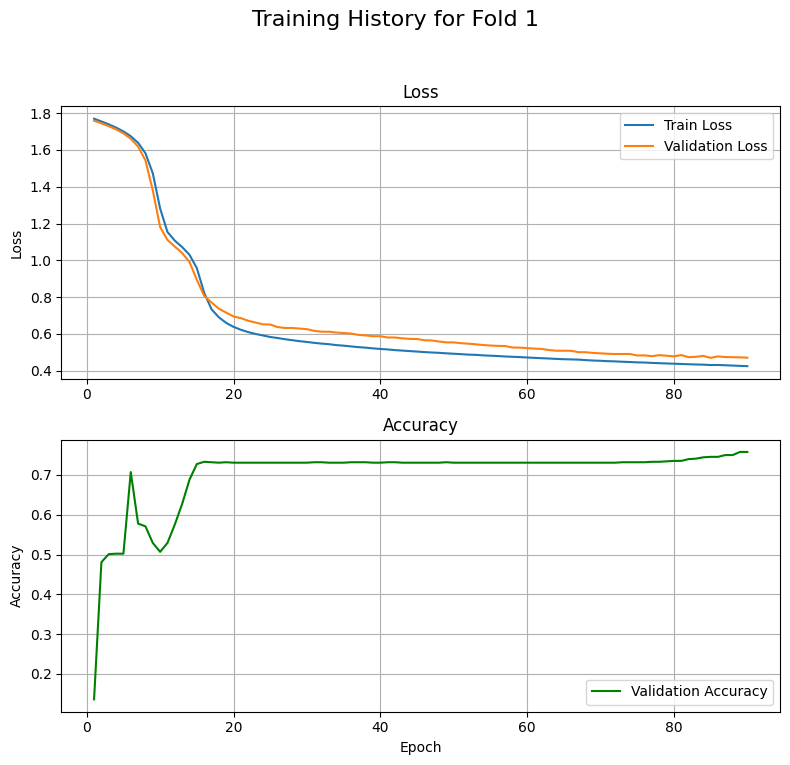

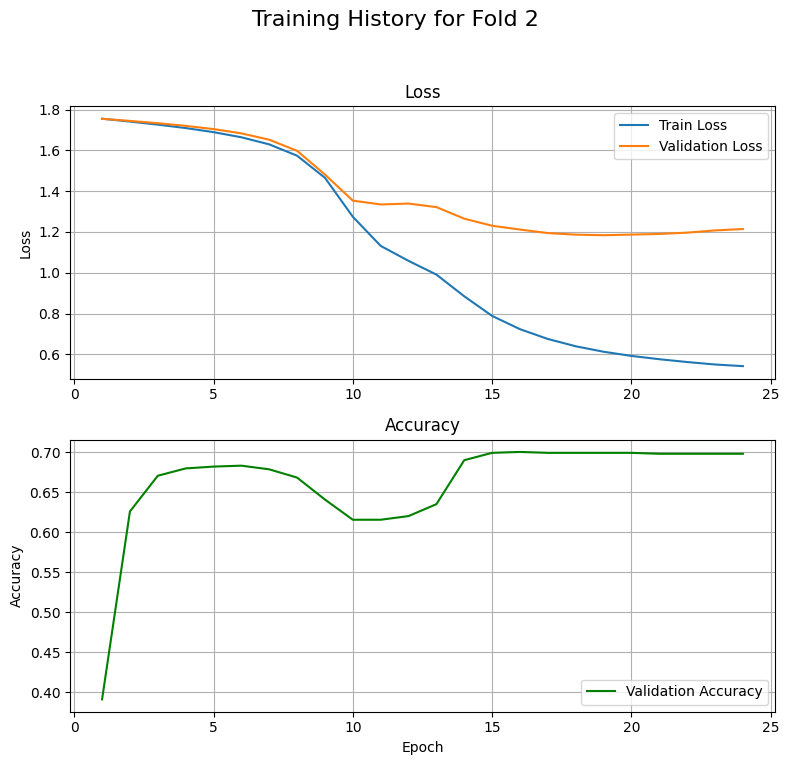

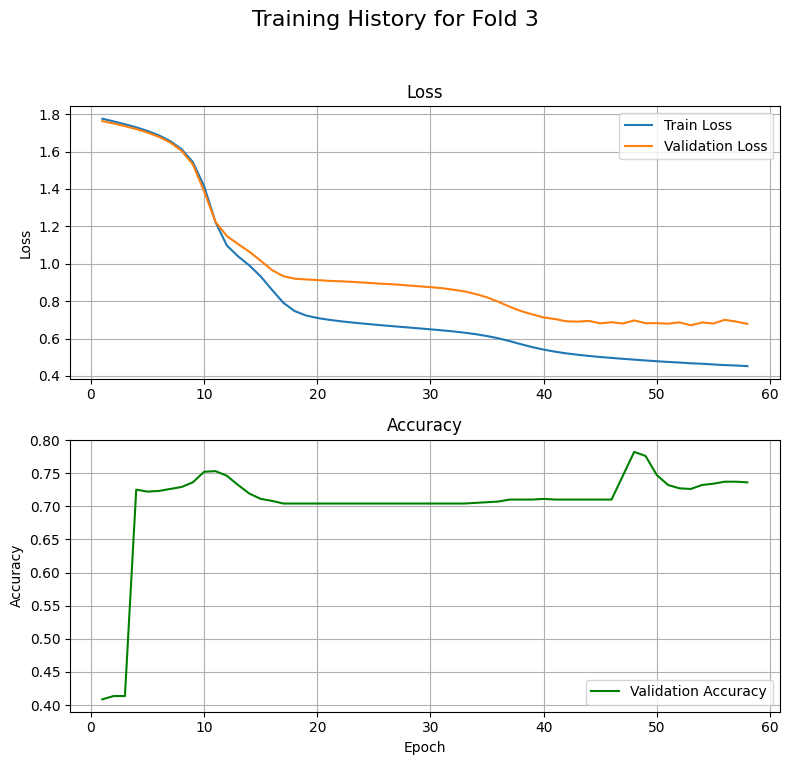

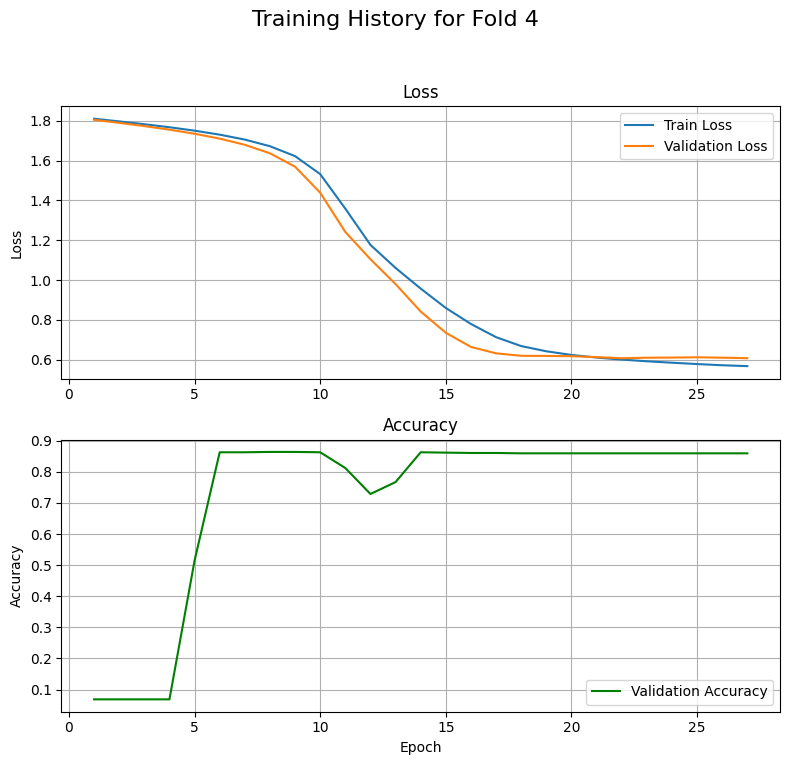

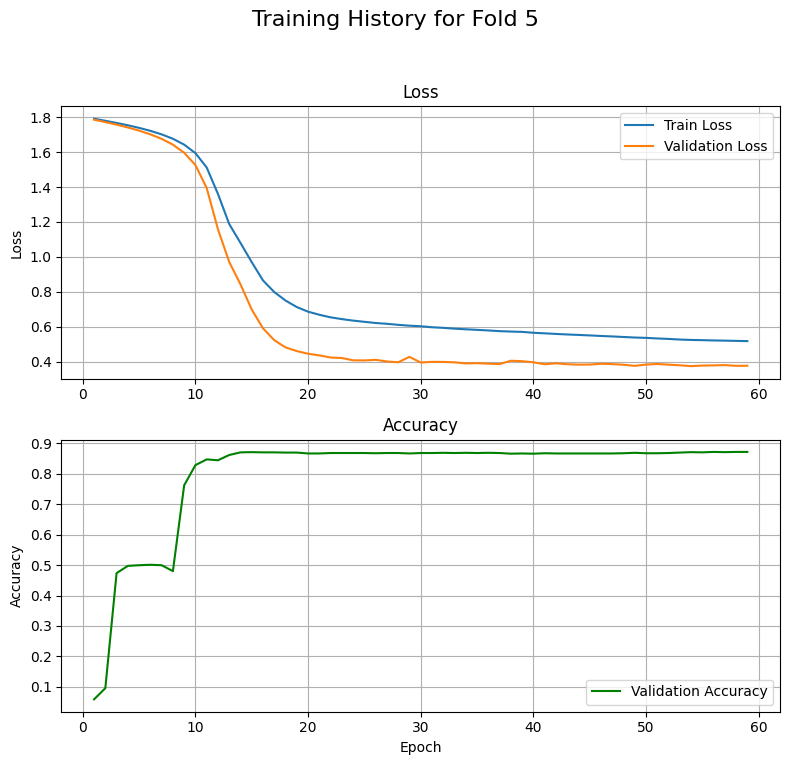

In [25]:
import matplotlib.pyplot as plt

for hist in fold_histories:
    fold = hist['fold']
    epochs = len(hist['history']['train_loss']) # Assuming train_loss, val_loss, and val_acc have the same length
    epoch_range = range(1, epochs + 1)

    # Create a figure and a set of subplots for each fold
    fig, axes = plt.subplots(2, 1, figsize=(8, 8))
    fig.suptitle(f'Training History for Fold {fold}', fontsize=16)

    # Plot Training and Validation Loss
    axes[0].plot(epoch_range, hist['history']['train_loss'], label='Train Loss')
    axes[0].plot(epoch_range, hist['history']['val_loss'], label='Validation Loss')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Loss')
    axes[0].legend()
    axes[0].grid(True)

    # Plot Validation Accuracy
    axes[1].plot(epoch_range, hist['history']['val_acc'], label='Validation Accuracy', color='green')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent suptitle overlap
    plt.show()

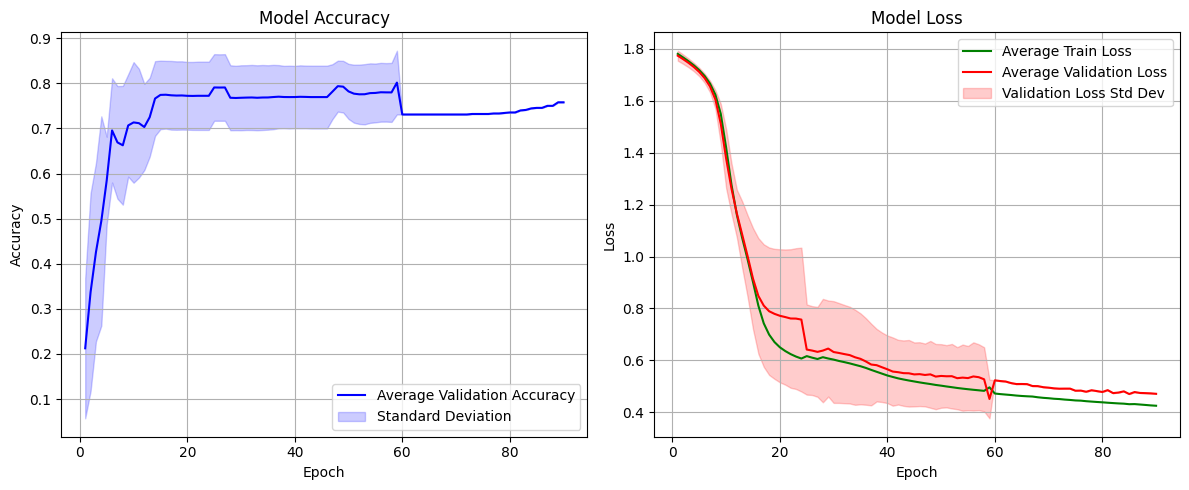

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. 데이터 준비 (Fold별 길이가 달라도 처리 가능하도록) ---
# 이전 코드에서 fold_histories 리스트에 결과가 저장되어 있다고 가정

# 각 Fold의 history 리스트 추출
train_losses_folds = [h['history']['train_loss'] for h in fold_histories]
test_losses_folds = [h['history']['val_loss'] for h in fold_histories]
test_acc_folds = [h['history']['val_acc'] for h in fold_histories]

# 가장 길게 학습한 에폭 수 찾기
max_epochs = max([len(h) for h in train_losses_folds])

# NumPy 배열로 변환 (길이가 짧은 Fold는 NaN으로 채움)
def pad_history(histories, max_len):
    padded = np.full((len(histories), max_len), np.nan)
    for i, h in enumerate(histories):
        padded[i, :len(h)] = h
    return padded

all_train_losses = pad_history(train_losses_folds, max_epochs)
all_test_losses = pad_history(test_losses_folds, max_epochs)
all_test_accs = pad_history(test_acc_folds, max_epochs)

# --- 2. 평균 및 표준편차 계산 ---
mean_train_loss = np.nanmean(all_train_losses, axis=0)
std_train_loss = np.nanstd(all_train_losses, axis=0)

mean_test_loss = np.nanmean(all_test_losses, axis=0)
std_test_loss = np.nanstd(all_test_losses, axis=0)

mean_test_acc = np.nanmean(all_test_accs, axis=0)
std_test_acc = np.nanstd(all_test_accs, axis=0)

# --- 3. 그래프 그리기 ---
epoch_range = range(1, max_epochs + 1)

# 정확도(Accuracy) 그래프
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epoch_range, mean_test_acc, 'b-', label='Average Validation Accuracy')
plt.fill_between(epoch_range,
                 mean_test_acc - std_test_acc,
                 mean_test_acc + std_test_acc,
                 color='blue', alpha=0.2, label='Standard Deviation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# 손실(Loss) 그래프
plt.subplot(1, 2, 2)
plt.plot(epoch_range, mean_train_loss, 'g-', label='Average Train Loss')
plt.plot(epoch_range, mean_test_loss, 'r-', label='Average Validation Loss')
plt.fill_between(epoch_range,
                 mean_test_loss - std_test_loss,
                 mean_test_loss + std_test_loss,
                 color='red', alpha=0.2, label='Validation Loss Std Dev')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [28]:
# --- 💡 새로운 부분: 전체 훈련 데이터로 재학습 ---
print(f"\n===================== Retraining on Full Training Data =====================")
# 1. CV에서 찾은 최적의 에포크 수를 평균내어 결정 (소수점 버림)
optimal_epochs = int(np.mean(stopped_epochs))
print(f"Optimal epochs determined from CV: {optimal_epochs}")

# 2. 전체 훈련 데이터를 위한 DataLoader 생성
X_train_full, y_train_full = get_frames(train_df, frame_size, hop_size)
X_train_full_tensor = torch.tensor(X_train_full, dtype=torch.float32)
y_train_full_tensor = torch.tensor(y_train_full, dtype=torch.long)

full_train_dataset = TensorDataset(X_train_full_tensor, y_train_full_tensor)
full_train_loader = DataLoader(full_train_dataset, batch_size=batch_size, shuffle=True)

# 3. 최종 모델을 위한 새로운 모델 객체 생성 및 초기화
final_model = LSTMClassifier(input_size=4, hidden_size=100, num_layers=2, num_classes=6).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(final_model.parameters(), lr=0.00001, weight_decay=1e-4)

# 4. 전체 훈련 데이터로 `optimal_epochs` 만큼 학습
for epoch in range(optimal_epochs):
    final_model.train()
    running_loss = 0.0
    for inputs, labels in full_train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = final_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    
    epoch_loss = running_loss / len(full_train_loader.dataset)
    print(f"Retraining Epoch [{epoch+1}/{optimal_epochs}], Loss: {epoch_loss:.4f}")

print("Retraining finished.")



===================== Retraining on Full Training Data =====================
Optimal epochs determined from CV: 98
Retraining Epoch [1/98], Loss: 1.7767
Retraining Epoch [2/98], Loss: 1.7594
Retraining Epoch [3/98], Loss: 1.7406
Retraining Epoch [4/98], Loss: 1.7184
Retraining Epoch [5/98], Loss: 1.6899
Retraining Epoch [6/98], Loss: 1.6493
Retraining Epoch [7/98], Loss: 1.5802
Retraining Epoch [8/98], Loss: 1.4336
Retraining Epoch [9/98], Loss: 1.2133
Retraining Epoch [10/98], Loss: 1.0958
Retraining Epoch [11/98], Loss: 1.0354
Retraining Epoch [12/98], Loss: 0.9780
Retraining Epoch [13/98], Loss: 0.9004
Retraining Epoch [14/98], Loss: 0.8063
Retraining Epoch [15/98], Loss: 0.7480
Retraining Epoch [16/98], Loss: 0.7232
Retraining Epoch [17/98], Loss: 0.7062
Retraining Epoch [18/98], Loss: 0.6901
Retraining Epoch [19/98], Loss: 0.6718
Retraining Epoch [20/98], Loss: 0.6496
Retraining Epoch [21/98], Loss: 0.6240
Retraining Epoch [22/98], Loss: 0.6005
Retraining Epoch [23/98], Loss: 0.5


===================== Final Evaluation with Retrained Model =====================

### Final Test Set Classification Report ###
              precision    recall  f1-score   support

  Downstairs       0.11      0.02      0.04       384
     Jogging       0.98      0.94      0.96      1313
     Sitting       0.56      0.95      0.71        63
    Standing       0.00      0.00      0.00        48
    Upstairs       0.35      0.72      0.47       405
     Walking       0.80      0.77      0.79      1328

    accuracy                           0.74      3541
   macro avg       0.47      0.57      0.49      3541
weighted avg       0.73      0.74      0.72      3541


### Final Test Set Confusion Matrix ###


c:\Users\c\Desktop\ML programming\venv\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\c\Desktop\ML programming\venv\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\c\Desktop\ML programming\venv\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

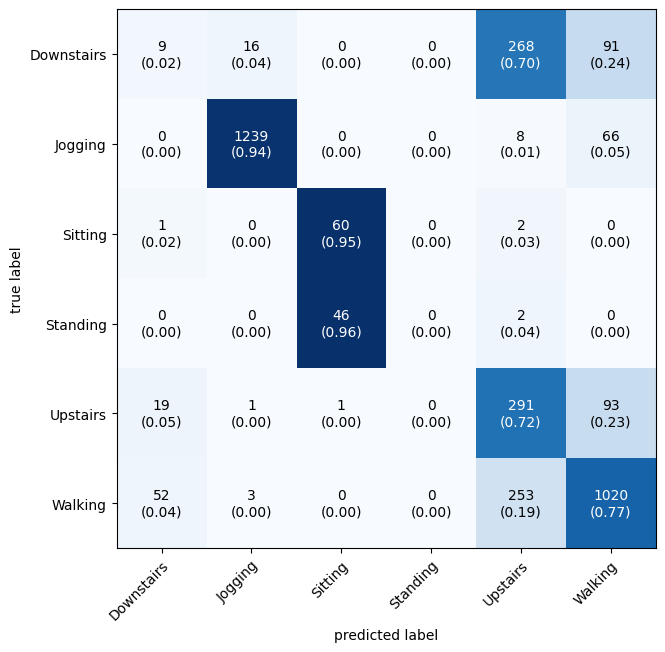

In [30]:
print(f"\n===================== Final Evaluation with Retrained Model =====================")
final_model.eval() # 평가 모드로 설정

# 테스트 데이터 준비 (기존 코드와 동일)
feature_cols = ['x_std', 'y_std', 'z_std', 'magnitude_std']
X_test, y_test = get_frames(test_df, frame_size, hop_size)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# final_model을 사용하여 최종 예측 수행
all_test_predictions = []
all_test_labels = []
with torch.no_grad():
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = final_model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_test_predictions.extend(predicted.cpu().numpy())
        all_test_labels.extend(labels.numpy())
        
# 최종 결과 분석 및 시각화 (기존 코드와 동일)
from sklearn.metrics import classification_report, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

print("\n### Final Test Set Classification Report ###")
print(classification_report(all_test_labels, all_test_predictions, target_names=label_encoder.classes_))

print("\n### Final Test Set Confusion Matrix ###")
mat = confusion_matrix(all_test_labels, all_test_predictions)
plot_confusion_matrix(
    conf_mat=mat,
    class_names=label_encoder.classes_,
    show_normed=True,
    figsize=(7, 7)
)
plt.show()